In [ ]:
!pip install langdetect
!pip install datasets

import os
import re
import string
import time
import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import tqdm
import collections
import gensim.downloader as api

from collections import Counter
from gensim.models import KeyedVectors, Word2Vec
from langdetect import detect
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Embedding
from datasets import Dataset


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing

In [ ]:
df_train = pd.read_csv("sent_train.csv")
df_test = pd.read_csv("sent_valid.csv")

df = pd.concat([df_train, df_test], ignore_index=True)

def remove_dollar_words(text):
    return re.sub(r'\$\w+', '', text)

df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)

df['text'] = df['text'].apply(remove_dollar_words)

df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

df['text'] = df['text'].str.replace(r'\S*\d\S*', '', regex=True).str.replace(r'\d', '', regex=True)

df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '', regex=True)

df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

nlp = spacy.load('en_core_web_sm')

def remove_named_entities_spacy(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.ent_type_]
    return tokens

df["text"] = df["text"].apply(remove_named_entities_spacy)

df['text'] = df['text'].apply(lambda x: ' '.join(x)).str.lower().str.strip()

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df['is_english'] = df['text'].apply(is_english)

df = df[df['is_english']].drop(columns=['is_english'])

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

def tokenize_text(text):
    return word_tokenize(text)

df['text'] = df['text'].apply(tokenize_text).apply(remove_stopwords)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]

def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

start_time = time.time()
df['stemmed'] = df['text'].apply(stem_words)
end_time = time.time()
print("Time taken for stemming (first run): {} seconds".format(end_time - start_time))

start_time = time.time()
df['stemmed'] = df['text'].apply(stem_words)
end_time = time.time()
print("Time taken for stemming (subsequent run): {} seconds".format(end_time - start_time))

start_time = time.time()
df['lemmatized'] = df['text'].apply(lemmatize_words)
end_time = time.time()
print("Time taken for lemmatization (first run): {} seconds".format(end_time - start_time))

start_time = time.time()
df['lemmatized'] = df['text'].apply(lemmatize_words)
end_time = time.time()
print("Time taken for lemmatization (subsequent run): {} seconds".format(end_time - start_time))

df_test['lemmatized'] = df_test['text'].apply(lemmatize_words)
df_test['stemmed'] = df_test['text'].apply(stem_words)

df['joined'] = df['lemmatized'].apply(lambda x: ' '.join(x))

print(df['label'].unique())
from sklearn.model_selection import train_test_split

duplicates = df.duplicated(subset='joined', keep=False)
df = df[~duplicates]

df_train, df_test = train_test_split(df,test_size=0.2, random_state=42)

Time taken for stemming (first run): 6.61464786529541 seconds
Time taken for stemming (subsequent run): 5.913932800292969 seconds
Time taken for lemmatization (first run): 4.155223608016968 seconds
Time taken for lemmatization (subsequent run): 1.1104114055633545 seconds
[0 1 2]


* Time taken for stemming (first run): 1.8569550514221191 seconds
* Time taken for stemming (subsequent run): 1.8586277961730957 seconds seconds
* Time taken for lemmatization (first run): 2.727806806564331 seconds
* Time taken for lemmatization (subsequent run): 0.3878641128540039 seconds


In [ ]:
min_samples = len(df_train[df_train['label'] == 1])

df_majority_downsampled = resample(df_train[df_train['label'] == 2],
                                     replace=False,
                                     n_samples=min_samples,
                                     random_state=123)

df_train = pd.concat([df_majority_downsampled, df_train[df_train['label'] == 1], df_train[df_train['label'] == 0]])


In [ ]:
df_train

,text,label,stemmed,lemmatized,joined
515,"[media, stunner, china, next, country, cut, ra...",2,"[media, stunner, china, next, countri, cut, ra...","[medium, stunner, china, next, country, cut, r...",medium stunner china next country cut rate zero
4566,"[heres, advisors, anticipate, amid, billion, c...",2,"[here, advisor, anticip, amid, billion, charl,...","[here, advisor, anticipate, amid, billion, cha...",here advisor anticipate amid billion charles s...
6002,"[private, jet, business, gain, equity, stake, ...",2,"[privat, jet, busi, gain, equiti, stake, merge...","[private, jet, business, gain, equity, stake, ...",private jet business gain equity stake merger ...
4489,"[ft, editor, reviews, book, death, journalist]",2,"[ft, editor, review, book, death, journalist]","[ft, editor, review, book, death, journalist]",ft editor review book death journalist
1941,"[arrived, looks, nothing, like, pickup, truck,...",2,"[arriv, look, noth, like, pickup, truck, ever,...","[arrived, look, nothing, like, pickup, truck, ...",arrived look nothing like pickup truck ever se...
...,...,...,...,...,...
3006,"[refinery, fire, threatens, oil, demand]",0,"[refineri, fire, threaten, oil, demand]","[refinery, fire, threatens, oil, demand]",refinery fire threatens oil demand
10573,"[usdjpyhas, moved, phase, consolidation, near,...",0,"[usdjpyha, move, phase, consolid, near, figur,...","[usdjpyhas, moved, phase, consolidation, near,...",usdjpyhas moved phase consolidation near figur...
8957,"[pre, underperform, free, cash, flow, concerns...",0,"[pre, underperform, free, cash, flow, concern,...","[pre, underperform, free, cash, flow, concern,...",pre underperform free cash flow concern still ...
9673,"[grinds, higher, past, mildly, bid, around, tr...",0,"[grind, higher, past, mildli, bid, around, tra...","[grind, higher, past, mildly, bid, around, tra...",grind higher past mildly bid around trading up...


In [ ]:
df_train = df_train[df_train['lemmatized'].apply(len) > 2]
df_train

,text,label,stemmed,lemmatized,joined
515,"[media, stunner, china, next, country, cut, ra...",2,"[media, stunner, china, next, countri, cut, ra...","[medium, stunner, china, next, country, cut, r...",medium stunner china next country cut rate zero
4566,"[heres, advisors, anticipate, amid, billion, c...",2,"[here, advisor, anticip, amid, billion, charl,...","[here, advisor, anticipate, amid, billion, cha...",here advisor anticipate amid billion charles s...
6002,"[private, jet, business, gain, equity, stake, ...",2,"[privat, jet, busi, gain, equiti, stake, merge...","[private, jet, business, gain, equity, stake, ...",private jet business gain equity stake merger ...
4489,"[ft, editor, reviews, book, death, journalist]",2,"[ft, editor, review, book, death, journalist]","[ft, editor, review, book, death, journalist]",ft editor review book death journalist
1941,"[arrived, looks, nothing, like, pickup, truck,...",2,"[arriv, look, noth, like, pickup, truck, ever,...","[arrived, look, nothing, like, pickup, truck, ...",arrived look nothing like pickup truck ever se...
...,...,...,...,...,...
3006,"[refinery, fire, threatens, oil, demand]",0,"[refineri, fire, threaten, oil, demand]","[refinery, fire, threatens, oil, demand]",refinery fire threatens oil demand
10573,"[usdjpyhas, moved, phase, consolidation, near,...",0,"[usdjpyha, move, phase, consolid, near, figur,...","[usdjpyhas, moved, phase, consolidation, near,...",usdjpyhas moved phase consolidation near figur...
8957,"[pre, underperform, free, cash, flow, concerns...",0,"[pre, underperform, free, cash, flow, concern,...","[pre, underperform, free, cash, flow, concern,...",pre underperform free cash flow concern still ...
9673,"[grinds, higher, past, mildly, bid, around, tr...",0,"[grind, higher, past, mildli, bid, around, tra...","[grind, higher, past, mildly, bid, around, tra...",grind higher past mildly bid around trading up...


In [ ]:
#vectorizer = CountVectorizer()

#X_bow = vectorizer.fit_transform(df_train['joined'])

#token_counts = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())


In [ ]:
#tfidf_vectorizer = TfidfVectorizer()

#X_tfidf = tfidf_vectorizer.fit_transform(df_train['joined'])

## Dictionary approach + MultinomialNB

In [ ]:
start_time = time.time()
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)

df_train['sentiment'] = df_train['joined'].apply(get_sentiment)
df_train['compound'] = df_train['sentiment'].apply(lambda score_dict: score_dict['compound'])

def get_predicted_label(compound_score):
    if compound_score >= 0.05: #Start 0.05
        return 1
    elif compound_score <= -0.05:
        return 0
    else:
        return 2

df_train['predicted_label'] = df_train['compound'].apply(get_predicted_label)
end_time = time.time()
time_t = end_time - start_time

<ipython-input-16-433c002de73c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sentiment'] = df_train['joined'].apply(get_sentiment)
<ipython-input-16-433c002de73c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['compound'] = df_train['sentiment'].apply(lambda score_dict: score_dict['compound'])
<ipython-input-16-433c002de73c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [ ]:
accuracy = accuracy_score(df_train['label'], df_train['predicted_label'])
print(f'Accuracy: {accuracy}')
print(f'Time: {time_t}')

# Print classification report
report = classification_report(df_train['label'], df_train['predicted_label'])
print(report)

Accuracy: 0.4750045446282494
Time: 4.0317771434783936
              precision    recall  f1-score   support

           0       0.51      0.42      0.46      1705
           1       0.45      0.55      0.50      1920
           2       0.48      0.45      0.46      1876

    accuracy                           0.48      5501
   macro avg       0.48      0.47      0.47      5501
weighted avg       0.48      0.48      0.47      5501



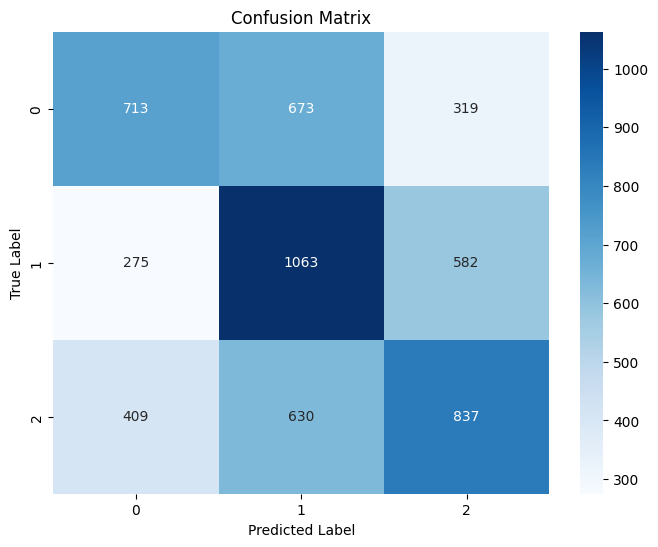

In [ ]:
conf_matrix = confusion_matrix(df_train['label'], df_train['predicted_label'], labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Accuracy: 0.6607929515418502
Running time: 35.56138062477112
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       438
           1       0.53      0.54      0.54       509
           2       0.77      0.79      0.78      1096

    accuracy                           0.66      2043
   macro avg       0.61      0.60      0.60      2043
weighted avg       0.66      0.66      0.66      2043



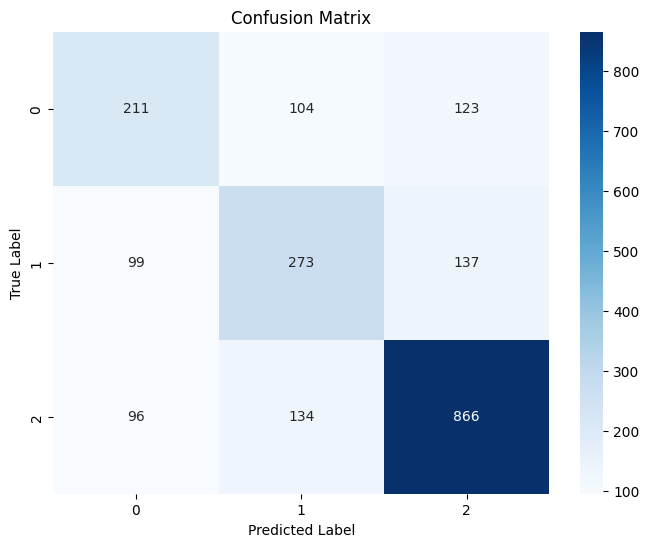

In [ ]:
start_time = time.time()
X_train = df_train['joined']
y_train = df_train['label']

X_test = df_test['joined']
y_test = df_test['label']

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

end_time = time.time()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(f"Running time: {end_time - start_time}")
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



Fitting 5 folds for each of 9 candidates, totalling 45 fits
Accuracy: 0.648556045031816
Running time: 34.990848779678345
              precision    recall  f1-score   support

           0       0.51      0.64      0.57       438
           1       0.50      0.65      0.56       509
           2       0.86      0.65      0.74      1096

    accuracy                           0.65      2043
   macro avg       0.62      0.65      0.62      2043
weighted avg       0.70      0.65      0.66      2043



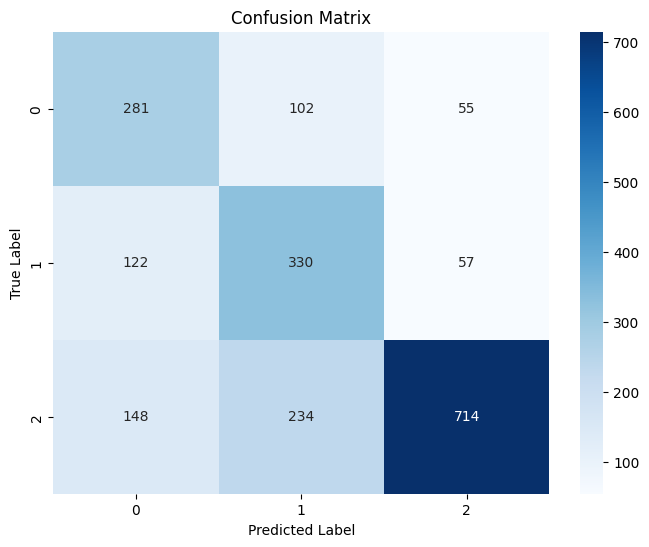

In [ ]:
start_time = time.time()
X_train = df_train['joined']
y_train = df_train['label']

X_test = df_test['joined']
y_test = df_test['label']

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

end_time = time.time()

conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print(f"Running time: {end_time - start_time}")
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



## CNNs

### CNN + BoW

In [ ]:
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df_train['joined']).toarray()
X_test = vectorizer.transform(df_test['joined']).toarray()

y_train = df_train['label'].values
y_test = df_test['label'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BoW_CNN(nn.Module):
    def __init__(self, input_dim):
        super(BoW_CNN, self).__init__()
        self.fc_reduce = nn.Linear(input_dim, 1024)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        conv_output_size = 1024 // 2
        self.fc1 = nn.Linear(conv_output_size * 100, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.fc_reduce(x)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = BoW_CNN(input_dim=5000).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.3f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

end_time = time.time()
print(f'Training and evaluation took {end_time - start_time:.2f} seconds.')


Epoch 1/10: 100%|██████████| 86/86 [00:54<00:00,  1.59it/s]


Epoch [1/10], Loss: 1.202


Epoch 2/10: 100%|██████████| 86/86 [00:48<00:00,  1.76it/s]


Epoch [2/10], Loss: 0.718


Epoch 3/10: 100%|██████████| 86/86 [00:52<00:00,  1.65it/s]


Epoch [3/10], Loss: 0.443


Epoch 4/10: 100%|██████████| 86/86 [00:50<00:00,  1.72it/s]


Epoch [4/10], Loss: 0.237


Epoch 5/10: 100%|██████████| 86/86 [00:49<00:00,  1.74it/s]


Epoch [5/10], Loss: 0.123


Epoch 6/10: 100%|██████████| 86/86 [00:51<00:00,  1.67it/s]


Epoch [6/10], Loss: 0.076


Epoch 7/10: 100%|██████████| 86/86 [00:49<00:00,  1.73it/s]


Epoch [7/10], Loss: 0.041


Epoch 8/10: 100%|██████████| 86/86 [00:53<00:00,  1.61it/s]


Epoch [8/10], Loss: 0.031


Epoch 9/10: 100%|██████████| 86/86 [01:01<00:00,  1.40it/s]


Epoch [9/10], Loss: 0.020


Epoch 10/10: 100%|██████████| 86/86 [01:03<00:00,  1.35it/s]


Epoch [10/10], Loss: 0.021
Accuracy: 64.22%
Training and evaluation took 869.22 seconds.


Running time: 869.2177135944366
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       438
           1       0.50      0.70      0.58       509
           2       0.88      0.63      0.73      1096

    accuracy                           0.64      2043
   macro avg       0.62      0.64      0.62      2043
weighted avg       0.70      0.64      0.65      2043



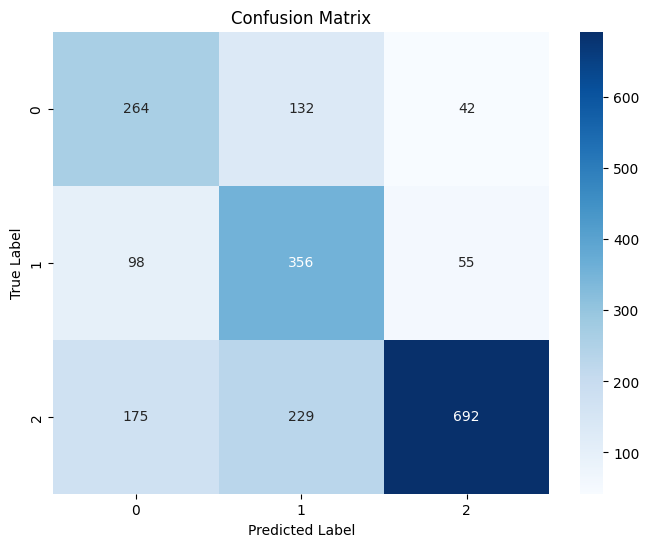

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print(f"Running time: {end_time - start_time}")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### CNN + Word2Vec

In [ ]:
train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

In [ ]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

word2vec_model = api.load("word2vec-google-news-300")

counter = Counter()
for tokens in train_data['lemmatized']:
    counter.update(tokens)

vocab = torchtext.vocab.vocab(counter, min_freq=min_freq, specials=special_tokens)

embedding_dim = word2vec_model.vector_size
pretrained_embedding = torch.zeros(len(vocab), embedding_dim)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

for i, token in enumerate(vocab.get_itos()):
    if token in word2vec_model:
        pretrained_embedding[i] = torch.tensor(word2vec_model[token])
    elif token == '<unk>':
        pretrained_embedding[i] = torch.randn(embedding_dim)
    elif token == '<pad>':
        pretrained_embedding[i] = torch.zeros(embedding_dim)
    else:
        pretrained_embedding[i] = pretrained_embedding[unk_index]

vocab.set_default_index(unk_index)

def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

train_data = train_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 500

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        #kernel_size,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
          [
            nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_size, embedding_dim)
            )
            for filter_size in filter_sizes
          ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]

        embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, seq len, embedding dim]

        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n = [batch size, n_filters, seq len - filter_size + 1, 1]

        pooled = [torch.max(conv, dim=2).values for conv in conved]
        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]

        prediction = self.fc(cat)
        # prediction = [batch size, output_dim]

        return prediction

vocab_size = len(vocab)
embedding_dim = 300
n_filters = 50
filter_sizes = [1, 2, 3]
#kernel_size = [3, 4, 5]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.5

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    #kernel_size,
    output_dim,
    dropout_rate,
    pad_index,
)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Map:   0%|          | 0/5508 [00:00<?, ? examples/s]

Map:   0%|          | 0/2047 [00:00<?, ? examples/s]

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [ ]:
model.apply(initialize_weights)
model.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=False, padding_idx=pad_index)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
start_time = time.time()
n_epochs = 10
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "cnn.pt")
    #torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

evaluating...: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


epoch: 0
train_loss: 1.131, train_acc: 0.375
valid_loss: 0.904, valid_acc: 0.600


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


epoch: 1
train_loss: 0.944, train_acc: 0.555
valid_loss: 0.884, valid_acc: 0.652


evaluating...: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


epoch: 2
train_loss: 0.870, train_acc: 0.614
valid_loss: 0.821, valid_acc: 0.683


evaluating...: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


epoch: 3
train_loss: 0.799, train_acc: 0.653
valid_loss: 0.790, valid_acc: 0.699


evaluating...: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


epoch: 4
train_loss: 0.779, train_acc: 0.663
valid_loss: 0.761, valid_acc: 0.687


evaluating...: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


epoch: 5
train_loss: 0.708, train_acc: 0.691
valid_loss: 0.723, valid_acc: 0.730


evaluating...: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


epoch: 6
train_loss: 0.668, train_acc: 0.725
valid_loss: 0.709, valid_acc: 0.725


evaluating...: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


epoch: 7
train_loss: 0.605, train_acc: 0.757
valid_loss: 0.678, valid_acc: 0.726


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


epoch: 8
train_loss: 0.563, train_acc: 0.784
valid_loss: 0.688, valid_acc: 0.729


evaluating...: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


epoch: 9
train_loss: 0.531, train_acc: 0.792
valid_loss: 0.665, valid_acc: 0.745


Running time: 1531.2673914432526
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       446
           1       0.61      0.66      0.64       501
           2       0.85      0.84      0.85      1100

    accuracy                           0.74      2047
   macro avg       0.70      0.70      0.70      2047
weighted avg       0.75      0.74      0.75      2047



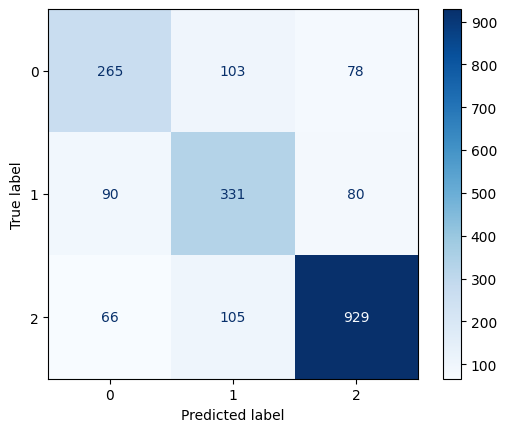

In [ ]:
model.load_state_dict(torch.load("cnn.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = get_predictions(test_data_loader, model, device)

print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### CNN + GloVe

In [ ]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['lemmatized'],
    min_freq=min_freq,
    specials=special_tokens,
)
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/5508 [00:00<?, ? examples/s]

Map:   0%|          | 0/2047 [00:00<?, ? examples/s]

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 500

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        #kernel_size,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
          [
            nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_size, embedding_dim)
            )
            for filter_size in filter_sizes
          ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]

        embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, seq len, embedding dim]

        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved_n = [batch size, n_filters, seq len - filter_size + 1, 1]

        pooled = [torch.max(conv, dim=2).values for conv in conved]
        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]

        prediction = self.fc(cat)
        # prediction = [batch size, output_dim]

        return prediction


In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 50
filter_sizes = [1, 2, 3]
#kernel_size = [3, 4, 5]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.5

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    #kernel_size,
    output_dim,
    dropout_rate,
    pad_index,
)

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)
vectors = torchtext.vocab.GloVe()


.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [07:01<00:00, 5211.79it/s]


In [ ]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [ ]:
model.embedding.weight.data = pretrained_embedding

In [ ]:
optimizer = optim.Adam(model.parameters())#,lr=0.0005)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
start_time = time.time()
n_epochs = 10
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "cnn.pt")
    #torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


epoch: 0
train_loss: 1.038, train_acc: 0.450
valid_loss: 0.870, valid_acc: 0.641


evaluating...: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


epoch: 1
train_loss: 0.843, train_acc: 0.613
valid_loss: 0.775, valid_acc: 0.686


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


epoch: 2
train_loss: 0.782, train_acc: 0.637
valid_loss: 0.762, valid_acc: 0.697


evaluating...: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


epoch: 3
train_loss: 0.762, train_acc: 0.650
valid_loss: 0.717, valid_acc: 0.708


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


epoch: 4
train_loss: 0.696, train_acc: 0.705
valid_loss: 0.730, valid_acc: 0.717


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


epoch: 5
train_loss: 0.662, train_acc: 0.711
valid_loss: 0.688, valid_acc: 0.731


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


epoch: 6
train_loss: 0.623, train_acc: 0.740
valid_loss: 0.683, valid_acc: 0.736


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


epoch: 7
train_loss: 0.585, train_acc: 0.766
valid_loss: 0.678, valid_acc: 0.742


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


epoch: 8
train_loss: 0.547, train_acc: 0.794
valid_loss: 0.669, valid_acc: 0.740


evaluating...: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


epoch: 9
train_loss: 0.533, train_acc: 0.790
valid_loss: 0.667, valid_acc: 0.737


In [ ]:
model.load_state_dict(torch.load("cnn.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = get_predictions(test_data_loader, model, device)

Running time: 1468.5246164798737
              precision    recall  f1-score   support

           0       0.63      0.53      0.58       446
           1       0.59      0.70      0.64       501
           2       0.86      0.83      0.84      1100

    accuracy                           0.73      2047
   macro avg       0.69      0.69      0.69      2047
weighted avg       0.74      0.73      0.74      2047



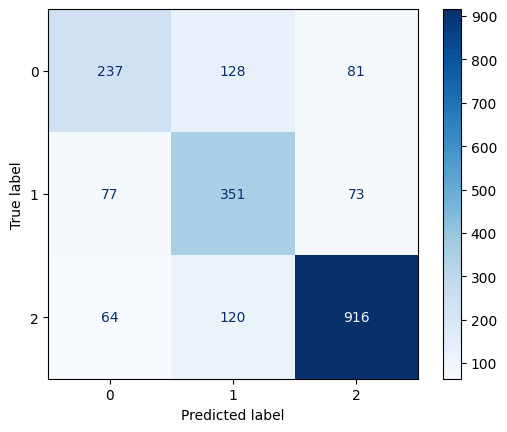

In [ ]:
print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## RNNs

### RNN + BoW

In [ ]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(df_train['joined']).toarray()
X_test_bow = vectorizer.transform(df_test['joined']).toarray()

# Convert features and labels to tensors and move to device
X_train_tensor = torch.tensor(X_train_bow, dtype=torch.float32)
y_train_tensor = torch.tensor(df_train['label'].values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_bow, dtype=torch.float32)
y_test_tensor = torch.tensor(df_test['label'].values, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
class BoWLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BoWLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        print(f'Input to LSTM shape: {x.shape}')  # Debugging line
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        print(f'LSTM output shape: {hn.shape}')  # Debugging line
        out = self.fc(hn[-1])
        print(f'Final output shape: {out.shape}')  # Debugging line
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_bow.shape[1]  # BoW vector size
hidden_size = 128
output_size = 3  # Number of classes, updated to 3

model = BoWLSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)

        print(f'Predicted output shape: {output.shape}')  # Debugging line
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Testing the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')
end_time = time.time()

Показано результат, скорочений до останніх рядків (5000).
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Predicted output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 

Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final output shape: torch.Size([3, 3])
Input to LSTM shape: torch.Size([3, 1, 12049])
LSTM output shape: torch.Size([1, 3, 128])
Final o

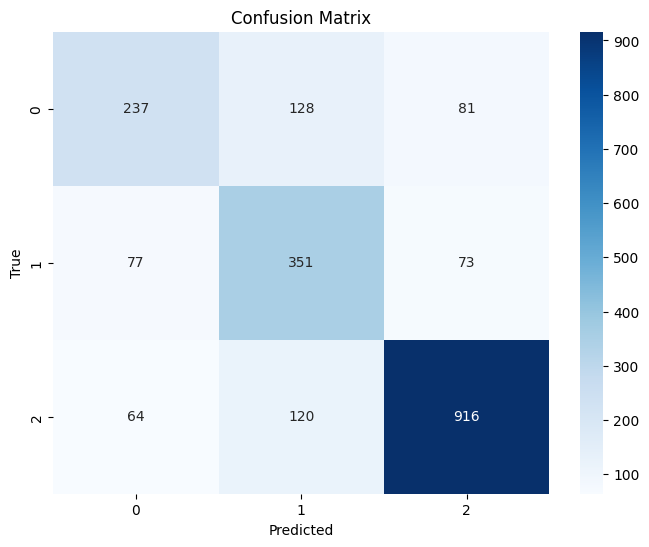

In [ ]:
all_preds = []
all_labels = []

# Testing the model and collecting predictions
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.unsqueeze(1).to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Calculate the accuracy
accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
print(f'Accuracy: {accuracy:.2f}%')

# Classification report
print(f"Running time: {end_time - start_time}")
print(classification_report(all_labels, all_preds))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### RNN + Word2Vec

In [ ]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

word2vec_model = api.load("word2vec-google-news-300")

train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

def add_length_column(example):
    example['length'] = len(example['lemmatized'])
    return example

train_data = train_data.map(add_length_column)
test_data = test_data.map(add_length_column)

counter = Counter()
for tokens in train_data['lemmatized']:
    counter.update(tokens)

vocab = torchtext.vocab.vocab(counter, min_freq=min_freq, specials=special_tokens)

embedding_dim = word2vec_model.vector_size
pretrained_embedding = torch.zeros(len(vocab), embedding_dim)
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

for i, token in enumerate(vocab.get_itos()):
    if token in word2vec_model:
        pretrained_embedding[i] = torch.tensor(word2vec_model[token])
    elif token == '<unk>':
        pretrained_embedding[i] = torch.randn(embedding_dim)
    elif token == '<pad>':
        pretrained_embedding[i] = torch.zeros(embedding_dim)
    else:
        pretrained_embedding[i] = pretrained_embedding[unk_index]

vocab.set_default_index(unk_index)

[==============================--------------------] 60.7% 1010.0/1662.8MB downloaded

ContentTooShortError: <urlopen error retrieval incomplete: got only 1059061760 out of 1743563840 bytes>

In [ ]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

model.apply(initialize_weights)

model.embedding = Embedding.from_pretrained(pretrained_embedding, freeze=False, padding_idx=pad_index)

lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


In [ ]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
start_time = time.time()
n_epochs = 10
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

In [ ]:
model.load_state_dict(torch.load("lstm.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            lengths = batch["length"]

            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Assuming test_data_loader is your DataLoader object for the test set
test_preds, test_labels = get_predictions(test_data_loader, model, device)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### RNN + GloVe

In [ ]:
train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

def add_length_column(example):
    example['length'] = len(example['lemmatized'])
    return example

train_data = train_data.map(add_length_column)
test_data = test_data.map(add_length_column)

In [ ]:
min_freq = 2
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['lemmatized'],
    min_freq=min_freq,
    specials=special_tokens,
)
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["lemmatized"])
    return {"ids": ids}

train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [ ]:
model.apply(initialize_weights)
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
start_time = time.time()
n_epochs = 10
best_test_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["test_losses"].append(test_loss)
    metrics["test_accs"].append(test_acc)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {test_loss:.3f}, valid_acc: {test_acc:.3f}")
end_time = time.time()

In [ ]:
model.load_state_dict(torch.load("lstm.pt"))

def get_predictions(data_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["ids"].to(device)
            labels = batch["label"].to(device)
            lengths = batch["length"]

            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = get_predictions(test_data_loader, model, device)


In [ ]:
print(f"Running time: {end_time - start_time}")
report = classification_report(test_labels, test_preds, zero_division=0)
print(report)

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()